LSC 519: Final Project
By: Greg Finkelberg

In [26]:
# Import libraries
import os
import time
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import re 
import numpy as np
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.service import Service
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers, optimizers
from collections import Counter

print("All libraries imported successfully!")

All libraries imported successfully!


In [ ]:
# Specify the path to your GeckoDriver in the Downloads folder
driver_path = 'C:\\Users\\Greg\\Downloads\\geckodriver.exe'
service = Service(driver_path)
driver = webdriver.Firefox(service=service)

# Base URL template for accessing each resource folder
base_url_template = 'https://mother-db.org/resource-folder/?path=MDB{:07d}'

# Create directories to save images and XML files
os.makedirs('MOTHER_images', exist_ok=True)
os.makedirs('MOTHER_metadata', exist_ok=True)

# Loop through each resource folder from MDB0000001 to MDB0000428
for i in range(1, 429):  # Now set to loop through all 428 folders
    # Generate the URL for the current resource folder
    resource_url = base_url_template.format(i)
    print(f"Accessing: {resource_url}")

    # Open the resource folder page using Selenium
    driver.get(resource_url)
    time.sleep(2)  # Wait for the page to load completely

    # Use BeautifulSoup to parse the fully rendered HTML content
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Find all <a> tags to get file links
    links = soup.find_all('a', href=True)
    
    # Debug: Print all links found on the page
    print(f"Links found on {resource_url}:")
    for link in links:
        print(link['href'])

    # Initialize variables for image and XML file URLs
    image_url = None
    xml_url = None

    # Identify the URLs for the reduced image and the XML metadata file
    for link in links:
        href = link['href']
        if '_reduced.png' in href:
            image_url = href if href.startswith("http") else 'https://mother-db.org' + href
        elif href.endswith('.xml'):
            xml_url = href if href.startswith("http") else 'https://mother-db.org' + href

    # Debug: Print the constructed URLs
    print(f"Constructed image URL: {image_url}")
    print(f"Constructed XML URL: {xml_url}")

    # Download the reduced image
    if image_url:
        try:
            img_response = requests.get(image_url)
            img_response.raise_for_status()  # Raise an error for bad responses
            img_filename = os.path.join('MOTHER_images', f'MDB{i:07d}_reduced.png')
            with open(img_filename, 'wb') as img_file:
                img_file.write(img_response.content)
            print(f"Downloaded image: {img_filename}")
        except Exception as e:
            print(f"Failed to download image: {image_url} - Error: {e}")

    # Download the XML metadata file
    if xml_url:
        try:
            xml_response = requests.get(xml_url)
            xml_response.raise_for_status()  # Raise an error for bad responses
            xml_filename = os.path.join('MOTHER_metadata', f'MDB{i:07d}.xml')
            with open(xml_filename, 'wb') as xml_file:
                xml_file.write(xml_response.content)
            print(f"Downloaded XML: {xml_filename}")
        except Exception as e:
            print(f"Failed to download XML: {xml_url} - Error: {e}")

# Close the browser
driver.quit()

        Common Name           Donor ID Donor Sex Donor Age (Years)  \
0  Japanese macaque  MZ_MF_20478-F1-09    female                 0   
1  Japanese macaque  MZ_MF_20478-F1-09    female                 0   
2  Japanese macaque  MZ_MF_20478-F1-09    female                 0   
3  Japanese macaque  MZ_MF_20478-F1-09    female                 0   
4  Japanese macaque  MZ_MF_20478-F1-09    female                 0   

  Donor Age (Days) Life Stage                  Stain  
0              130      fetal  Hematoxylin and Eosin  
1              130      fetal  Hematoxylin and Eosin  
2              130      fetal  Hematoxylin and Eosin  
3              130      fetal  Hematoxylin and Eosin  
4              130      fetal  Hematoxylin and Eosin  


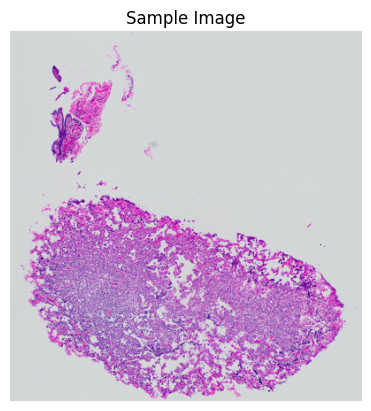

In [27]:
# Directory containing the XML files
xml_dir = 'MOTHER_metadata'

# Namespace dictionary to handle the XML namespaces
namespaces = {
    'eml': 'https://eml.ecoinformatics.org/eml-2.2.0',
    'mdb': 'http://mother-db.org/mdb'
}

# List to store metadata
metadata_list = []

# Loop through each XML file and extract relevant information
for xml_file in os.listdir(xml_dir):
    if xml_file.endswith('.xml'):
        file_path = os.path.join(xml_dir, xml_file)
        
        # Parse the XML file
        tree = ET.parse(file_path)
        root = tree.getroot()
        
        # Extract the species-level common name
        species_common_name = root.find('.//taxonomicClassification[taxonRankName="Species"]/commonName', namespaces)
        species_common_name_text = species_common_name.text if species_common_name is not None else 'N/A'
        
        # Extract other metadata fields
        donor_id = root.find('.//mdb:donorID', namespaces).text if root.find('.//mdb:donorID', namespaces) is not None else 'N/A'
        donor_sex = root.find('.//mdb:donorSex', namespaces).text if root.find('.//mdb:donorSex', namespaces) is not None else 'N/A'
        donor_age_years = root.find('.//mdb:donorYears', namespaces).text if root.find('.//mdb:donorYears', namespaces) is not None else 'N/A'
        donor_age_days = root.find('.//mdb:donorDays', namespaces).text if root.find('.//mdb:donorDays', namespaces) is not None else 'N/A'
        life_stage = root.find('.//mdb:donorLifeStage', namespaces).text if root.find('.//mdb:donorLifeStage', namespaces) is not None else 'N/A'
        stain = root.find('.//mdb:hematoxylinAndEosin', namespaces) is not None  # Check if stain exists
        
        # Append extracted data to the list
        metadata_list.append({
            'Common Name': species_common_name_text,
            'Donor ID': donor_id,
            'Donor Sex': donor_sex,
            'Donor Age (Years)': donor_age_years,
            'Donor Age (Days)': donor_age_days,
            'Life Stage': life_stage,
            'Stain': 'Hematoxylin and Eosin' if stain else 'N/A'
        })

# Convert the metadata list to a DataFrame
metadata_df = pd.DataFrame(metadata_list)

# Display the first few rows of the DataFrame
print(metadata_df.head())

# Directory containing the images
image_dir = 'MOTHER_images'

# Load and display a sample image
sample_image_path = os.path.join(image_dir, 'MDB0000001_reduced.png')
image = cv2.imread(sample_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title('Sample Image')
plt.axis('off')
plt.show()

Common Name
Rhesus macaque         142
Japanese macaque       112
Cynomolgus macaque      51
rainbow trout           26
Fathead Minnow          20
Dzhungarian hamster     18
Japanese killifish      13
House Mouse             12
redside shiner          12
Name: count, dtype: int64


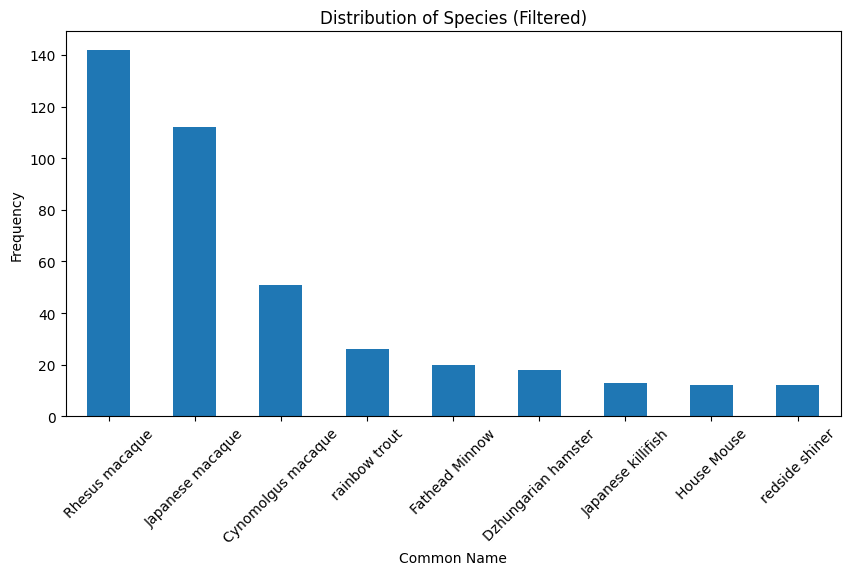

In [19]:
# Remove rows where "Common Name" is 'N/A'
metadata_df = metadata_df[metadata_df['Common Name'] != 'N/A']

# Set a threshold for the minimum number of samples required
sample_threshold = 10

# Calculate the counts for each common name
species_counts = metadata_df['Common Name'].value_counts()

# Filter the dataset to include only species with at least 'sample_threshold' samples
metadata_df = metadata_df[metadata_df['Common Name'].isin(species_counts[species_counts >= sample_threshold].index)]

# Print the updated counts for each common name
print(metadata_df['Common Name'].value_counts())

# Proceed with the data analysis or visualization
metadata_df['Common Name'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Distribution of Species (Filtered)')
plt.xlabel('Common Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Checking path: MOTHER_images\MDB0000001_reduced.png
Checking path: MOTHER_images\MDB0000002_reduced.png
Checking path: MOTHER_images\MDB0000003_reduced.png
Checking path: MOTHER_images\MDB0000004_reduced.png
Checking path: MOTHER_images\MDB0000005_reduced.png
Checking path: MOTHER_images\MDB0000006_reduced.png
Checking path: MOTHER_images\MDB0000007_reduced.png
Checking path: MOTHER_images\MDB0000008_reduced.png
Checking path: MOTHER_images\MDB0000009_reduced.png
Checking path: MOTHER_images\MDB0000010_reduced.png
Checking path: MOTHER_images\MDB0000011_reduced.png
Checking path: MOTHER_images\MDB0000012_reduced.png
Checking path: MOTHER_images\MDB0000013_reduced.png
Checking path: MOTHER_images\MDB0000014_reduced.png
Checking path: MOTHER_images\MDB0000015_reduced.png
Checking path: MOTHER_images\MDB0000016_reduced.png
Checking path: MOTHER_images\MDB0000017_reduced.png
Checking path: MOTHER_images\MDB0000018_reduced.png
Checking path: MOTHER_images\MDB0000019_reduced.png
Checking pat

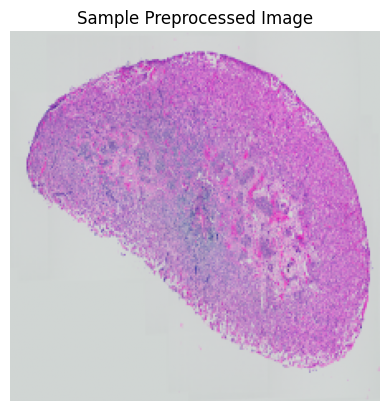

In [34]:
# Prepare labels and image paths
image_paths = []
labels = []

# Loop through each row in the filtered metadata
for index, row in metadata_df.iterrows():
    # Construct the image filename using the index number in the format MDB0000001_reduced.png
    image_filename = f"MDB{index+1:07d}_reduced.png"
    image_path = os.path.join(image_dir, image_filename)
    
    # Debug: Print each constructed image path
    print(f"Checking path: {image_path}")
    
    if os.path.exists(image_path):
        image_paths.append(image_path)
        labels.append(row['Common Name'])
    else:
        print(f"Image not found: {image_path}")

# Check if image_paths and labels have been populated
print(f"Number of images found: {len(image_paths)}")
print(f"Number of labels: {len(labels)}")

# Filter classes with fewer than 2 samples
from collections import Counter

# Calculate the counts for each label
label_counts = Counter(labels)

# Filter out classes with fewer than 2 samples
filtered_indices = [i for i, label in enumerate(labels) if label_counts[label] >= 2]
image_paths = [image_paths[i] for i in filtered_indices]
labels = [labels[i] for i in filtered_indices]

# Check the new counts for each label
print(f"Updated number of images: {len(image_paths)}")
print(f"Updated number of labels: {len(labels)}")

# Ensure there are enough samples for splitting
if len(image_paths) == 0:
    raise ValueError("No images found after filtering. Please check the data distribution.")

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Display the number of images in each set
print(f"Number of training images: {len(train_paths)}")
print(f"Number of testing images: {len(test_paths)}")

# Function to preprocess and display a sample image
def preprocess_and_display_image(image_path):
    import cv2
    import matplotlib.pyplot as plt

    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Resize to 224x224 (example size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = image / 255.0  # Normalize pixel values
    plt.imshow(image)
    plt.title('Sample Preprocessed Image')
    plt.axis('off')
    plt.show()

# Display a sample preprocessed image if available
if len(train_paths) > 0:
    preprocess_and_display_image(train_paths[0])

In [36]:
# Convert labels to numerical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets (including the labels)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

# Convert labels to categorical format
train_labels_categorical = to_categorical(train_labels)
test_labels_categorical = to_categorical(test_labels)

# Function to load and preprocess images
def load_images(image_paths):
    images = []
    for path in image_paths:
        image = cv2.imread(path)
        image = cv2.resize(image, (224, 224))  # Resize to 224x224 for MobileNetV2
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image / 255.0  # Normalize pixel values
        images.append(image)
    return np.array(images)

# Load and preprocess the images
train_images = load_images(train_paths)
test_images = load_images(test_paths)

# Check if the number of images and labels match
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels_categorical.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels_categorical.shape)

Training images shape: (341, 224, 224, 3)
Training labels shape: (341, 15)
Testing images shape: (86, 224, 224, 3)
Testing labels shape: (86, 15)


In [35]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load MobileNetV2 with pretrained weights from ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

In [41]:
# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Another Dropout layer
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    datagen.flow(train_images, train_labels_categorical, batch_size=32),
    validation_data=(test_images, test_labels_categorical),
    epochs=30,
    callbacks=[early_stopping]
)

# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:  # Adjust the layer index as needed
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training with fine-tuning
history_fine = model.fit(
    datagen.flow(train_images, train_labels_categorical, batch_size=32),
    validation_data=(test_images, test_labels_categorical),
    epochs=20,
    callbacks=[early_stopping]
)

# Display the model summary
print(model.summary())

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 924ms/step - accuracy: 0.3384 - loss: 2.2710 - val_accuracy: 0.3372 - val_loss: 3.9222
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 776ms/step - accuracy: 0.7717 - loss: 0.8384 - val_accuracy: 0.1977 - val_loss: 6.1685
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 797ms/step - accuracy: 0.7869 - loss: 0.7488 - val_accuracy: 0.3721 - val_loss: 7.4693
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 820ms/step - accuracy: 0.8870 - loss: 0.4762 - val_accuracy: 0.3372 - val_loss: 10.6826
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 856ms/step - accuracy: 0.8588 - loss: 0.5547 - val_accuracy: 0.3605 - val_loss: 10.6352
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 850ms/step - accuracy: 0.9070 - loss: 0.3228 - val_accuracy: 0.3140 - val_loss: 13.8659
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 974ms/step - accuracy: 0.7484 - loss: 0.8903 - val_accuracy: 0.3256 - val_loss: 4.0430
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 938ms/step - accuracy: 0.7970 - loss: 0.8134 - val_accur

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,478,575 (24.71 MB)

 Trainable params: 2,027,343 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 4,054,688 (15.47 MB)

None


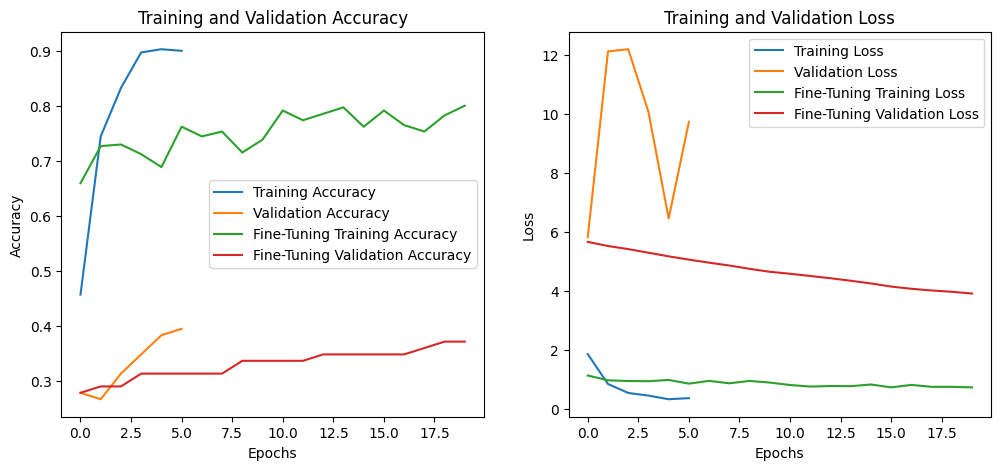

In [40]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-Tuning Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-Tuning Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-Tuning Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-Tuning Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()